In [92]:
#plotter per unire più run e più posterior
#------------------Import--------------------------------
from scipy import interpolate
from scipy import integrate
import scipy
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
import os 
import statistics as stat
folder='/home/rciancarella/DarkSirensStat/MyDSStat/results/'
os.chdir(folder)

In [93]:
runpath='P0_postback-scatter'
datapath=os.path.join(folder,runpath)
os.chdir(datapath)

# DS Cat

In [94]:
all_dls=np.loadtxt(runpath+'_DSs.txt', usecols=2)
all_zs=np.loadtxt(runpath+'_DSs.txt', usecols=3)
dl_max=np.max(all_dls)
dl_min=np.min(all_dls)
dl_med=dl_min+(dl_max-dl_min)/2
idx_max=np.where(all_dls==dl_max)[0][0]
idx_min=np.where(all_dls==dl_min)[0][0]
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

idx_med=np.where(all_dls==find_nearest(all_dls, value=dl_med))[0][0]

print(idx_min,idx_max,idx_med)

11 121 88


In [95]:
print(dl_max,np.max(all_zs))
print(dl_min,np.min(all_zs))

17906.83182705739 2.19648224910836
528.2394398027196 0.109329874637491


# $\beta$-Plot

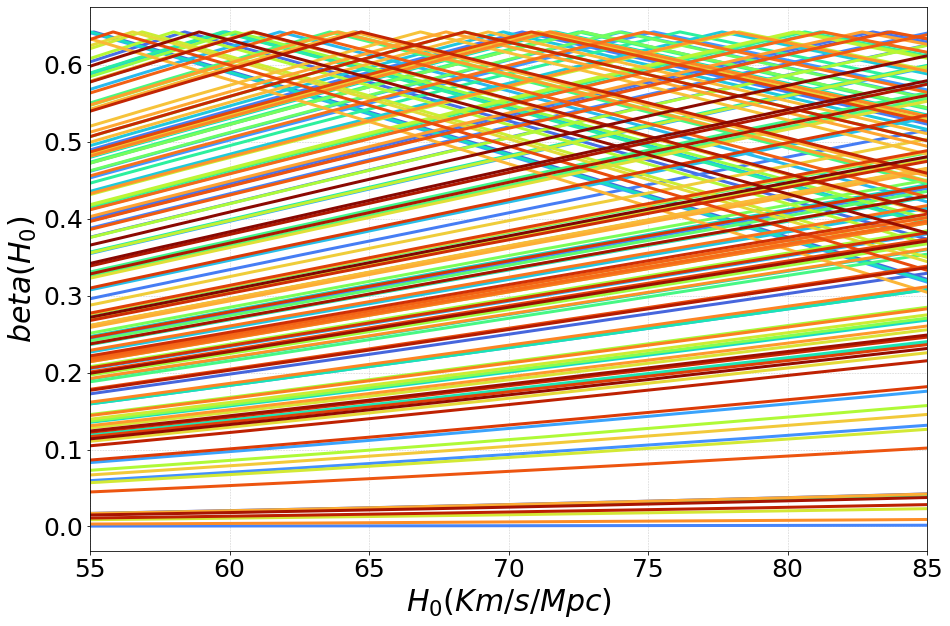

In [96]:
x=np.loadtxt(runpath+'_H0grid.txt')
xmin=np.min(x)
xmax=np.max(x)
#betavol=np.loadtxt('/home/rciancarella/DarkSirensStat/MyDSStat/results/volbeta/betatest_beta.txt')
betatest=np.loadtxt(runpath+'_beta.txt')

colors=pl.cm.turbo(np.linspace(0.1,0.99,len(betatest)))
fig, ax = plt.subplots(1, figsize=(15,10)) #crea un tupla che poi è più semplice da gestire
ax.tick_params(axis='both', which='major', labelsize=25)
ax.yaxis.get_offset_text().set_fontsize(25)
ax.grid(linestyle='dotted', linewidth='0.6')#griglia in sfondo

ax.set_xlim(xmin, xmax)
ax.set_xlabel(r'$H_0(Km/s/Mpc)$', fontsize=30)
#ax.set_ylabel(r'$P(H_0)$', fontsize=20)
ax.set_ylabel(r'$beta(H_0)$', fontsize=30)

for i in range(len(betatest)):
    ax.plot(x,betatest[i],color=colors[i],linewidth=3,label='betatest'+str(i))

#ax.plot(x,betatest[idx_max],label='betatest_dlmax',color='r',linewidth=4,linestyle='dashed')
#ax.plot(x,betatest[idx_min],label='betatest_dlmin',color='b',linewidth=4,linestyle='dotted')
#ax.plot(x,betatest[idx_med],label='betatest_dlmed',color='g',linewidth=4,linestyle='solid')
#ax.legend(fontsize=13, ncol=1)    

# Likelihood

In [97]:
likes=np.loadtxt(runpath +'_fullrun.txt')
NDS=np.shape(likes)[0]
#mybeta=np.loadtxt('/home/rciancarella/DarkSirensStat/MyDSStat/results/MyBeta/MyBeta_beta.txt')

In [98]:
NDS=np.shape(likes)[0]
final_post_by_like=[]
for i in range(NDS):
    final_post_by_like.append(likes[i]/betatest[i])
combined=[]
for i in range(len(final_post_by_like)):
    #combined=combined+post[i]
    if i==0:
        combined.append(final_post_by_like[i]*1)
    else:
        num=np.float128(combined[i-1]*(final_post_by_like[i]*1))
        combined.append(num)
totpost_like=combined[-1]

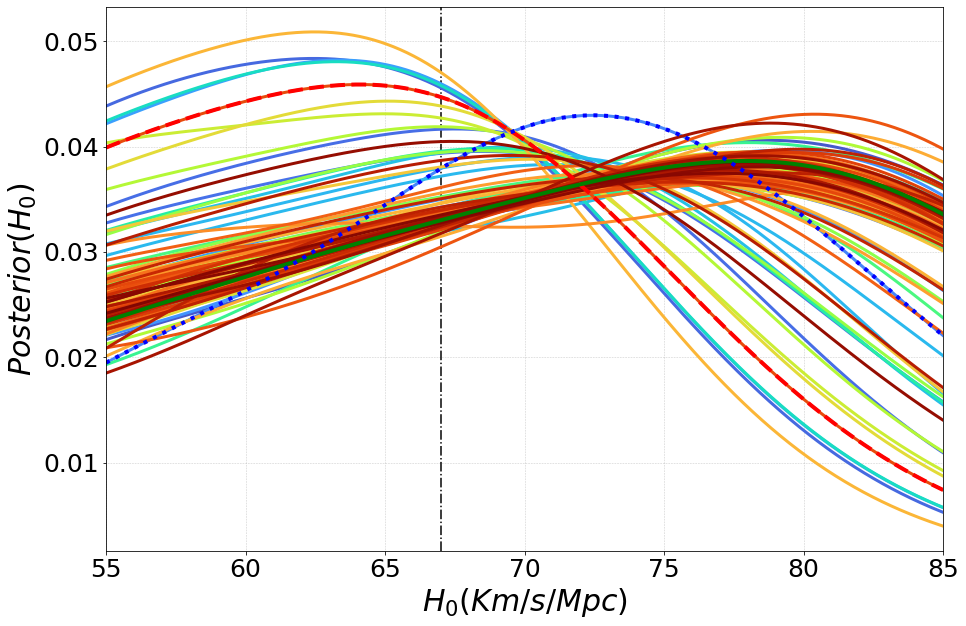

In [99]:
fig, ax = plt.subplots(1, figsize=(15,10)) #crea un tupla che poi è più semplice da gestire
ax.tick_params(axis='both', which='major', labelsize=25)
ax.yaxis.get_offset_text().set_fontsize(25)
ax.grid(linestyle='dotted', linewidth='0.6')#griglia in sfondo

href=67
ax.set_xlim(xmin, xmax)
ax.set_xlabel(r'$H_0(Km/s/Mpc)$', fontsize=30)
#ax.set_ylabel(r'$P(H_0)$', fontsize=20)
ax.set_ylabel(r'$Posterior(H_0)$', fontsize=30)
if xmin<href<xmax:
    ax.axvline(x = href, color = 'k', linestyle='dashdot',label = 'H0=67')

for i in range(len(betatest)):
    ax.plot(x,likes[i]/1/np.trapz(likes[i]/1,x),color=colors[i],linewidth=3)#,label='betatest'+str(i))
#ax.plot(x,totpost_like/np.trapz(totpost_like,x),label='Post',color='k',linewidth=4,linestyle='solid')
#------------------------------Single posteriors--------------------------------------
toplot=likes[idx_max]#/betatest[idx_max]
ax.plot(x,toplot/np.trapz(toplot,x),label='Post',color='r',linewidth=4,linestyle='dashed')

toplot=likes[idx_med]#/betatest[idx_med]
ax.plot(x,toplot/np.trapz(toplot,x),label='Post',color='g',linewidth=4,linestyle='solid')

toplot=likes[idx_min]#/betatest[idx_min]
ax.plot(x,toplot/np.trapz(toplot,x),label='Post',color='b',linewidth=4,linestyle='dotted')



# From Posterior

In [100]:
post=np.loadtxt(runpath+'_totpost.txt')

mean=69.42571682946523,std=2.648283058245057 std/mean=3.8145563044746114%


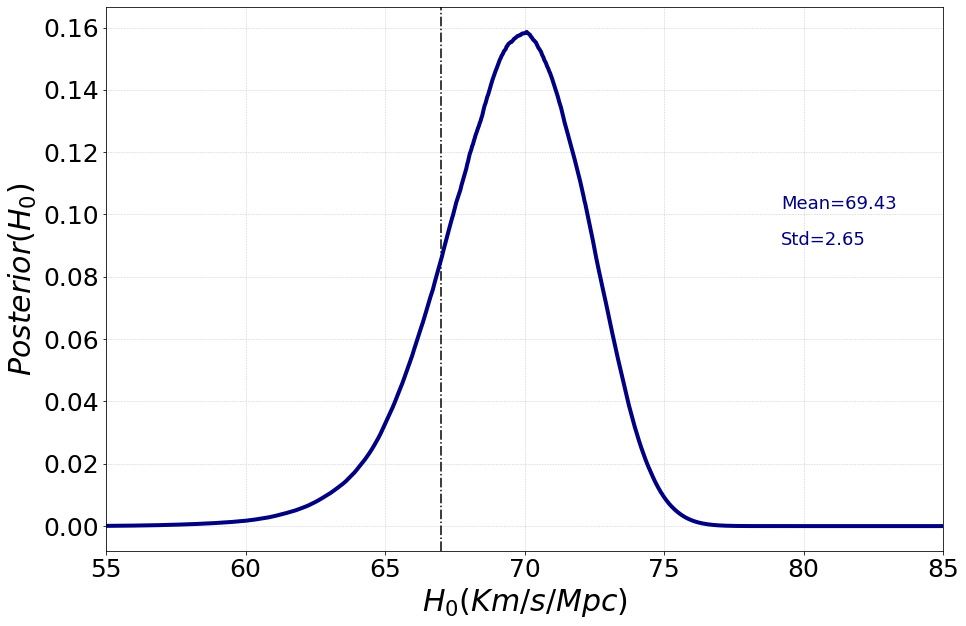

In [101]:
fig, ax = plt.subplots(1, figsize=(15,10)) #crea un tupla che poi è più semplice da gestire
ax.tick_params(axis='both', which='major', labelsize=25)
ax.yaxis.get_offset_text().set_fontsize(25)
ax.grid(linestyle='dotted', linewidth='0.6')#griglia in sfondo

href=67
ax.set_xlim(xmin, xmax)
ax.set_xlabel(r'$H_0(Km/s/Mpc)$', fontsize=30)
#ax.set_ylabel(r'$P(H_0)$', fontsize=20)
ax.set_ylabel(r'$Posterior(H_0)$', fontsize=30)
if xmin<href<xmax:
    ax.axvline(x = href, color = 'k', linestyle='dashdot',label = 'H0=67')

Mycol='navy'
Myshift='deeppink'
ax.plot(x,post/np.trapz(post,x),label='Post',color=Mycol,linewidth=4,linestyle='solid')
#ax.plot(x,totpost_like/np.trapz(totpost_like,x),label='Post',color=Myshift,linewidth=4,linestyle='solid')

newdist=(post)/np.trapz(post,x)
mean=np.trapz(x*newdist,x)/np.trapz(newdist,x)
std=np.sqrt(np.trapz(newdist*(x-mean)**2,x)/np.trapz(newdist,x))
plt.figtext(0.75,0.6,'Mean={:0.2f}'.format(mean),fontsize=18,c=Mycol)
plt.figtext(0.75,0.55,'Std={:0.2f}'.format(std),fontsize=18, c=Mycol)
print('mean={},std={} std/mean={}%'.format(mean,std,100*std/mean))

#dist=(totpost_like)/np.trapz(totpost_like,x)
#mean=np.trapz(x*dist,x)/np.trapz(dist,x)
#std=np.sqrt(np.trapz(dist*(x-mean)**2,x)/np.trapz(dist,x))
#plt.figtext(0.75,0.45,'Mean={:0.2f}'.format(mean),fontsize=18,c=Myshift)
#plt.figtext(0.75,0.40,'Std={:0.2f}'.format(std),fontsize=18, c=Myshift)
#print('mean={},std={} std/mean={}%'.format(mean,std,100*std/mean))

os.chdir(datapath)
#plt.savefig('PlotTot.pdf', format="pdf", bbox_inches="tight")

# Close Study 

In [102]:
import pandas as pd

In [103]:
DS_Cat = pd.read_csv(runpath+'_DSs.txt', sep=" ", header=None)
if DS_Cat.shape[1]==6:
    colnames=['Ngal','Comoving Distance','Luminosity Distance','z','phi','theta']
if DS_Cat.shape[1]==7:
    colnames=['Ngal','Comoving Distance','Luminosity Distance','z','phi','theta','scattered DL']
DS_Cat.columns=colnames
print(DS_Cat.shape[0])

150


In [104]:
DS_Cat.head(3)

,Ngal,Comoving Distance,Luminosity Distance,z,phi,theta,scattered DL
0,2689474,1618.082317,2267.900333,0.401598,0.475918,1.312600,2079.918700
1,151787,5099.303149,14536.916290,1.850765,1.049170,1.106915,14312.732145
2,1287984,4391.731895,10739.766275,1.445451,1.322997,1.332440,12436.963367


In [105]:
selected=DS_Cat[DS_Cat['z']>=2]
print(selected.shape[0])
selected.head()

25


,Ngal,Comoving Distance,Luminosity Distance,z,phi,theta,scattered DL
4,211928,5481.633685,17040.021608,2.108566,0.611414,0.678642,18855.928812
6,532400,5567.078374,17650.961019,2.170597,0.424429,0.649934,17379.342156
18,113897,5579.049370,17738.174406,2.179426,0.233124,1.118801,18929.649288
25,895421,5416.916696,16590.441474,2.062709,1.395937,0.497837,16820.939840
27,2116205,5428.128614,16667.534804,2.070586,0.712665,0.470687,17359.323185


In [106]:
myselection=np.asarray(selected.index.values)

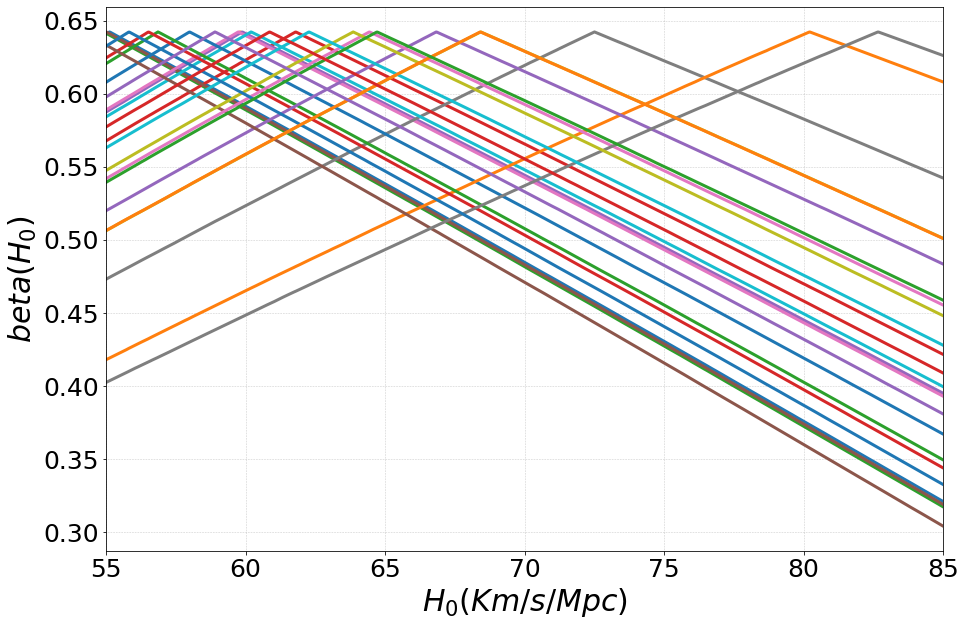

In [107]:
fig, ax = plt.subplots(1, figsize=(15,10)) #crea un tupla che poi è più semplice da gestire
ax.tick_params(axis='both', which='major', labelsize=25)
ax.yaxis.get_offset_text().set_fontsize(25)
ax.grid(linestyle='dotted', linewidth='0.6')#griglia in sfondo

ax.set_xlim(xmin, xmax)
ax.set_xlabel(r'$H_0(Km/s/Mpc)$', fontsize=30)
#ax.set_ylabel(r'$P(H_0)$', fontsize=20)
ax.set_ylabel(r'$beta(H_0)$', fontsize=30)
for i in myselection:
    ax.plot(x,betatest[i],linewidth=3,label='betatest'+str(i))
#ax.plot(x,betatest[idx_max],label='betatest_dlmax',color='r',linewidth=4,linestyle='dashed')

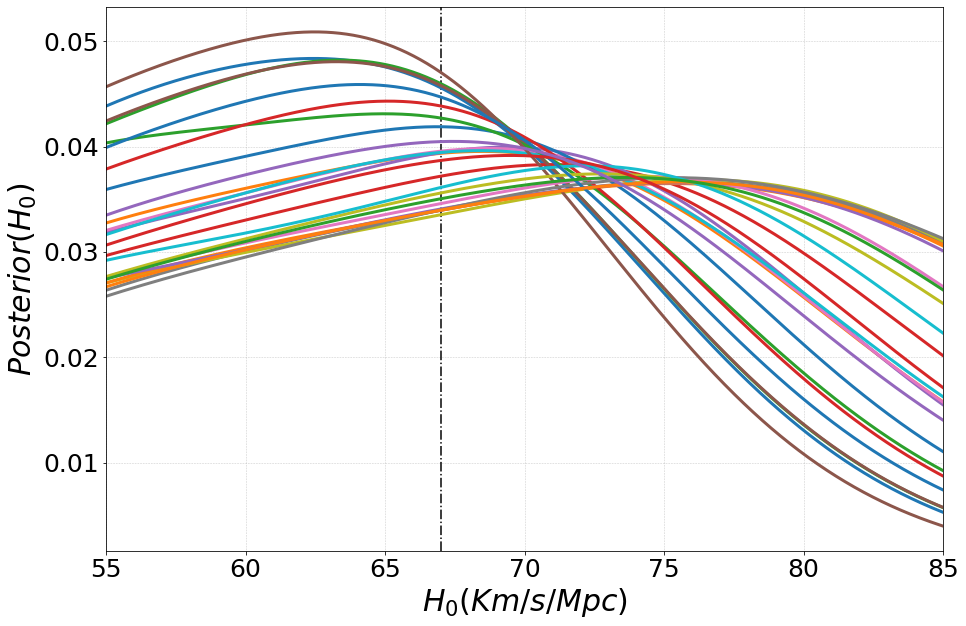

In [108]:
fig, ax = plt.subplots(1, figsize=(15,10)) #crea un tupla che poi è più semplice da gestire
ax.tick_params(axis='both', which='major', labelsize=25)
ax.yaxis.get_offset_text().set_fontsize(25)
ax.grid(linestyle='dotted', linewidth='0.6')#griglia in sfondo

href=67
ax.set_xlim(xmin, xmax)
ax.set_xlabel(r'$H_0(Km/s/Mpc)$', fontsize=30)
#ax.set_ylabel(r'$P(H_0)$', fontsize=20)
ax.set_ylabel(r'$Posterior(H_0)$', fontsize=30)
if xmin<href<xmax:
    ax.axvline(x = href, color = 'k', linestyle='dashdot',label = 'H0=67')
for i in myselection:
    toplot=likes[i]
    ax.plot(x,toplot/np.trapz(toplot,x),linewidth=3)
    

In [109]:
for i in myselection:
    final_post_by_like.append(likes[i]/betatest[i])
combined=[]
for i in range(len(final_post_by_like)):
    #combined=combined+post[i]
    if i==0:
        combined.append(final_post_by_like[i]*1)
    else:
        num=np.float128(combined[i-1]*(final_post_by_like[i]*1))
        combined.append(num)
totpost_like=combined[-1]

Text(0.75, 0.55, 'Std=1.96')

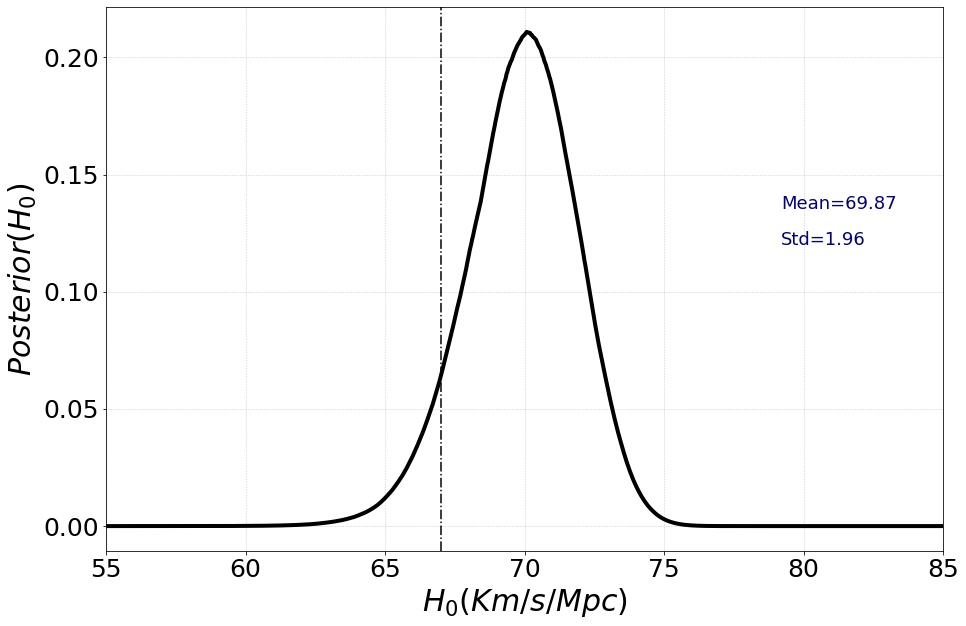

In [110]:
fig, ax = plt.subplots(1, figsize=(15,10)) #crea un tupla che poi è più semplice da gestire
ax.tick_params(axis='both', which='major', labelsize=25)
ax.yaxis.get_offset_text().set_fontsize(25)
ax.grid(linestyle='dotted', linewidth='0.6')#griglia in sfondo

href=67
ax.set_xlim(xmin, xmax)
ax.set_xlabel(r'$H_0(Km/s/Mpc)$', fontsize=30)
#ax.set_ylabel(r'$P(H_0)$', fontsize=20)
ax.set_ylabel(r'$Posterior(H_0)$', fontsize=30)
if xmin<href<xmax:
    ax.axvline(x = href, color = 'k', linestyle='dashdot',label = 'H0=67')
ax.plot(x,totpost_like/np.trapz(totpost_like,x),label='Post',color='k',linewidth=4,linestyle='solid')

newdist=(totpost_like)/np.trapz(totpost_like,x)
mean=np.trapz(x*newdist,x)/np.trapz(newdist,x)
std=np.sqrt(np.trapz(newdist*(x-mean)**2,x)/np.trapz(newdist,x))
plt.figtext(0.75,0.6,'Mean={:0.2f}'.format(mean),fontsize=18,c=Mycol)
plt.figtext(0.75,0.55,'Std={:0.2f}'.format(std),fontsize=18, c=Mycol)

In [111]:
selected=DS_Cat[DS_Cat['z']<=1]
print(selected.shape[0])
selected.head()

34


,Ngal,Comoving Distance,Luminosity Distance,z,phi,theta,scattered DL
0,2689474,1618.082317,2267.900333,0.401598,0.475918,1.312600,2079.918700
3,2206625,3371.199598,6685.125137,0.983011,0.526214,1.210379,6967.740507
11,2543150,476.178864,528.239440,0.109330,0.809362,0.986415,503.529546
14,226257,2692.754335,4666.318608,0.732917,0.557128,1.016229,3829.876958
15,355149,2986.465124,5484.850510,0.836569,0.258886,0.553958,6638.347641


In [112]:
myselection=np.asarray(selected.index.values)

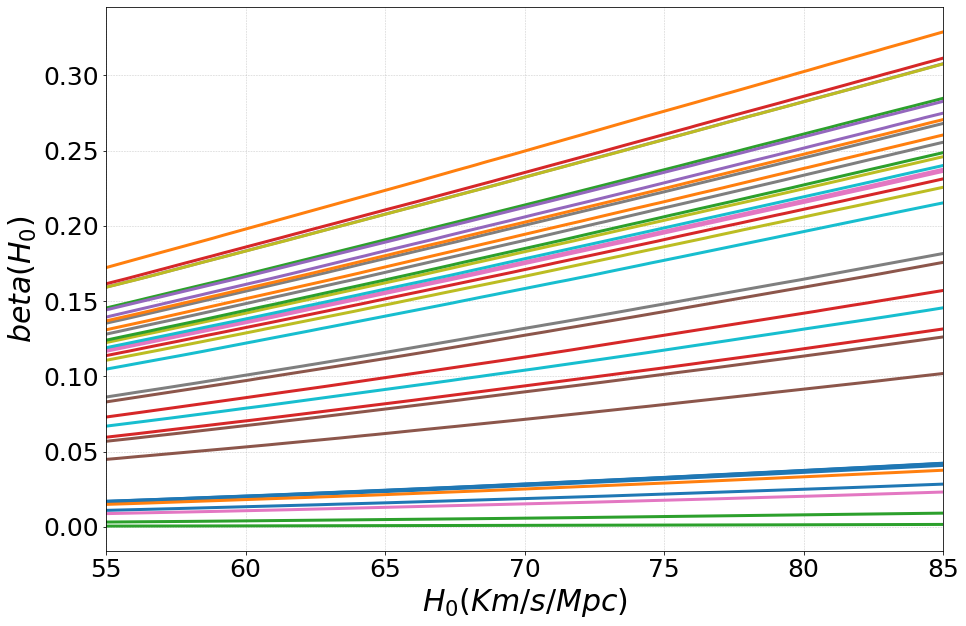

In [113]:
fig, ax = plt.subplots(1, figsize=(15,10)) #crea un tupla che poi è più semplice da gestire
ax.tick_params(axis='both', which='major', labelsize=25)
ax.yaxis.get_offset_text().set_fontsize(25)
ax.grid(linestyle='dotted', linewidth='0.6')#griglia in sfondo

ax.set_xlim(xmin, xmax)
ax.set_xlabel(r'$H_0(Km/s/Mpc)$', fontsize=30)
#ax.set_ylabel(r'$P(H_0)$', fontsize=20)
ax.set_ylabel(r'$beta(H_0)$', fontsize=30)
for i in myselection:
    ax.plot(x,betatest[i],linewidth=3,label='betatest'+str(i))
#ax.plot(x,betatest[idx_min],label='betatest_dlmin',color='b',linewidth=4,linestyle='dotted')

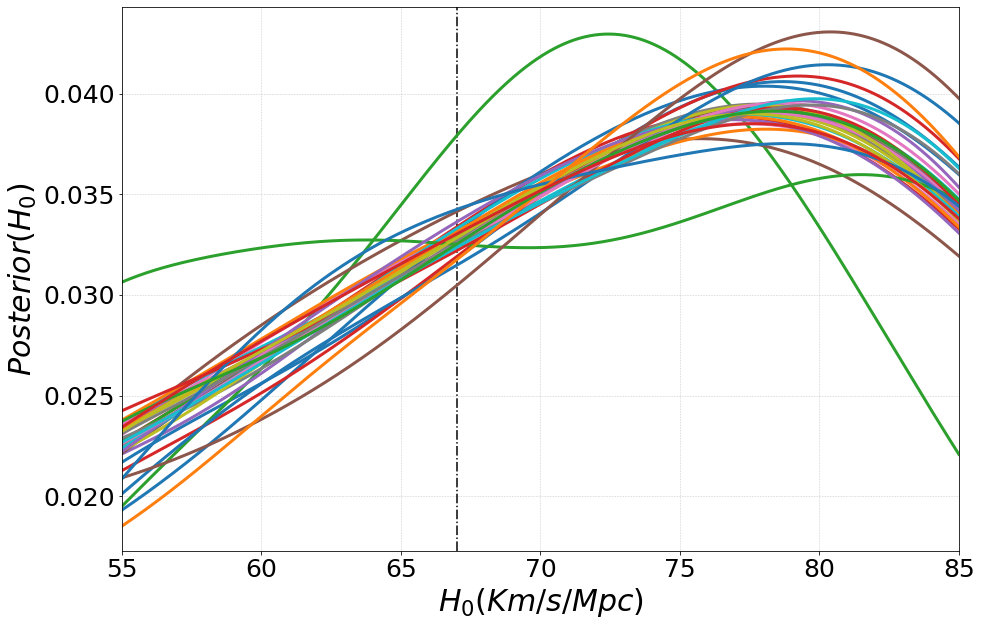

In [114]:
fig, ax = plt.subplots(1, figsize=(15,10)) #crea un tupla che poi è più semplice da gestire
ax.tick_params(axis='both', which='major', labelsize=25)
ax.yaxis.get_offset_text().set_fontsize(25)
ax.grid(linestyle='dotted', linewidth='0.6')#griglia in sfondo

href=67
ax.set_xlim(xmin, xmax)
ax.set_xlabel(r'$H_0(Km/s/Mpc)$', fontsize=30)
#ax.set_ylabel(r'$P(H_0)$', fontsize=20)
ax.set_ylabel(r'$Posterior(H_0)$', fontsize=30)
if xmin<href<xmax:
    ax.axvline(x = href, color = 'k', linestyle='dashdot',label = 'H0=67')
myselection_new= np.delete(myselection,[22])
for i in myselection:
    toplot=likes[i]
    ax.plot(x,toplot/np.trapz(toplot,x),linewidth=3)

In [115]:
for i in myselection:
    final_post_by_like.append(likes[i]/betatest[i])
combined=[]
for i in range(len(final_post_by_like)):
    #combined=combined+post[i]
    if i==0:
        combined.append(final_post_by_like[i]*1)
    else:
        num=np.float128(combined[i-1]*(final_post_by_like[i]*1))
        combined.append(num)
totpost_like=combined[-1]

Text(0.75, 0.55, 'Std=1.91')

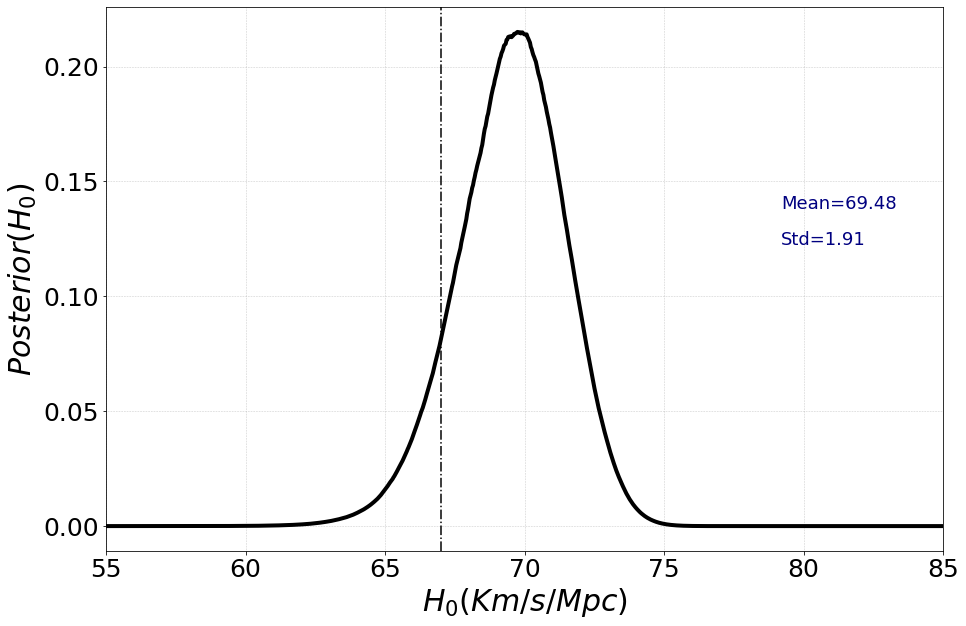

In [116]:
fig, ax = plt.subplots(1, figsize=(15,10)) #crea un tupla che poi è più semplice da gestire
ax.tick_params(axis='both', which='major', labelsize=25)
ax.yaxis.get_offset_text().set_fontsize(25)
ax.grid(linestyle='dotted', linewidth='0.6')#griglia in sfondo

href=67
ax.set_xlim(xmin, xmax)
ax.set_xlabel(r'$H_0(Km/s/Mpc)$', fontsize=30)
#ax.set_ylabel(r'$P(H_0)$', fontsize=20)
ax.set_ylabel(r'$Posterior(H_0)$', fontsize=30)
if xmin<href<xmax:
    ax.axvline(x = href, color = 'k', linestyle='dashdot',label = 'H0=67')
ax.plot(x,totpost_like/np.trapz(totpost_like,x),label='Post',color='k',linewidth=4,linestyle='solid')

newdist=(totpost_like)/np.trapz(totpost_like,x)
mean=np.trapz(x*newdist,x)/np.trapz(newdist,x)
std=np.sqrt(np.trapz(newdist*(x-mean)**2,x)/np.trapz(newdist,x))
plt.figtext(0.75,0.6,'Mean={:0.2f}'.format(mean),fontsize=18,c=Mycol)
plt.figtext(0.75,0.55,'Std={:0.2f}'.format(std),fontsize=18, c=Mycol)

# Scatter

In [117]:
import pandas as pd

In [118]:
scatter_runpath=runpath#'P0_postback-scatter'
scatter_datapath=os.path.join(folder,scatter_runpath)
os.chdir(scatter_datapath)

In [119]:
DS_Cat = pd.read_csv(runpath+'_DSs.txt', sep=" ", header=None)
if DS_Cat.shape[1]==6:
    colnames=['Ngal','Comoving Distance','Luminosity Distance','z','phi','theta']
    print('Dataframe has no Scatter')
if DS_Cat.shape[1]==7:
    colnames=['Ngal','Comoving Distance','Luminosity Distance','z','phi','theta','scattered DL']
DS_Cat.columns=colnames
print(DS_Cat.shape[0])

150


In [120]:
truedl=DS_Cat['Luminosity Distance']
scattereddl=DS_Cat['scattered DL']
diff=truedl-scattereddl
allsigma=0.1*truedl

Text(0, 0.5, '$N$')

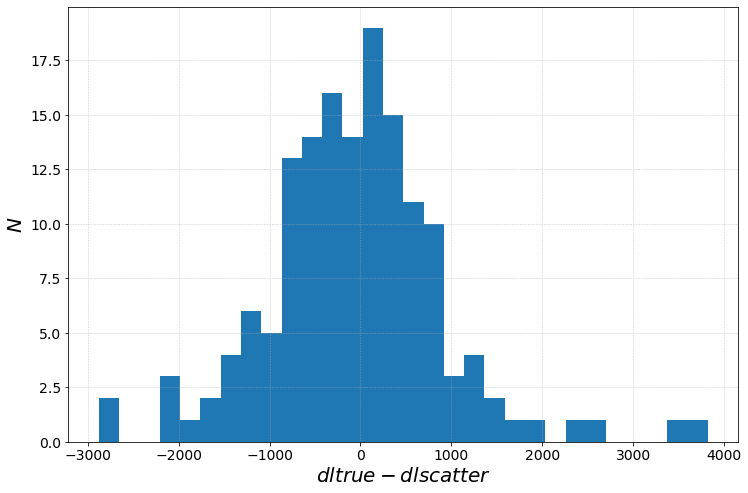

In [121]:
fig, ax = plt.subplots(1, figsize=(12,8)) #crea un tupla che poi è più semplice da gestire
ax.tick_params(axis='both', which='major', labelsize=14)
ax.yaxis.get_offset_text().set_fontsize(14)
ax.grid(linestyle='dotted', linewidth='0.6')#griglia in sfondo
colors=plt.cm.turbo(np.linspace(0.99,0.01,16))


nbins=30
(n, bins, patches)=ax.hist(diff,bins=nbins,range=(np.min(diff),np.max(diff)))

ax.set_xlabel(r'$dl true-dl scatter$', fontsize=20)
ax.set_ylabel(r'$N$', fontsize=20)

In [122]:
mean=np.mean(diff)
std=np.std(diff)
print(mean,std)

-54.81966032183301 974.8596389052854


In [129]:
norm_diff=diff/allsigma
test=norm_diff[norm_diff>=-1]
test=test[test<=1]
print(len(test)/len(norm_diff))

0.7933333333333333


In [125]:
print(allsigma[0],diff[0],truedl[0])

226.79003330902242 187.9816329665059 2267.900333090224


Text(0, 0.5, '$N$')

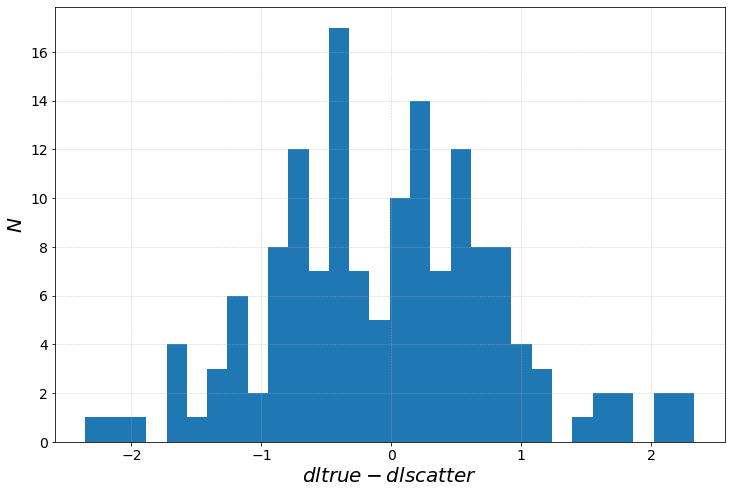

In [126]:
fig, ax = plt.subplots(1, figsize=(12,8)) #crea un tupla che poi è più semplice da gestire
ax.tick_params(axis='both', which='major', labelsize=14)
ax.yaxis.get_offset_text().set_fontsize(14)
ax.grid(linestyle='dotted', linewidth='0.6')#griglia in sfondo
colors=plt.cm.turbo(np.linspace(0.99,0.01,16))


nbins=30
(n_norm, bins_norm, patches)=ax.hist(norm_diff,bins=nbins,range=(np.min(norm_diff),np.max(norm_diff)))

ax.set_xlabel(r'$dl true-dl scatter$', fontsize=20)
ax.set_ylabel(r'$N$', fontsize=20)

In [127]:
mean=np.mean(norm_diff)
std=np.std(norm_diff)
print(mean,std)

-0.04462506454491925 0.8766794724837093


In [144]:
dl=np.linspace(1000,30000,8000)
scat=np.zeros(len(dl))
mysigma=dl*0.1
for i in range(len(dl)):
    scat[i]=np.random.normal(loc=dl[i], scale=mysigma[i], size=None)

In [145]:
mydiff=dl-scat
mynormdiff=mydiff/mysigma

Text(0, 0.5, '$N$')

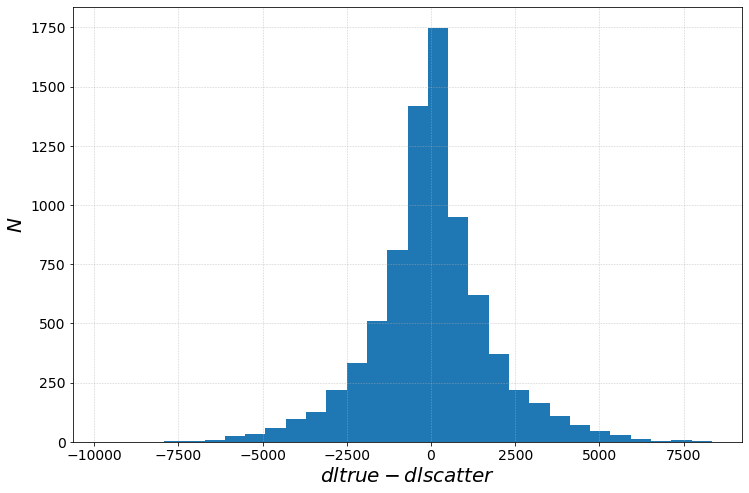

In [146]:
fig, ax = plt.subplots(1, figsize=(12,8)) #crea un tupla che poi è più semplice da gestire
ax.tick_params(axis='both', which='major', labelsize=14)
ax.yaxis.get_offset_text().set_fontsize(14)
ax.grid(linestyle='dotted', linewidth='0.6')#griglia in sfondo
colors=plt.cm.turbo(np.linspace(0.99,0.01,16))


nbins=30
(n, bins, patches)=ax.hist(mydiff,bins=nbins,range=(np.min(mydiff),np.max(mydiff)))

ax.set_xlabel(r'$dl true-dl scatter$', fontsize=20)
ax.set_ylabel(r'$N$', fontsize=20)

Text(0, 0.5, '$N$')

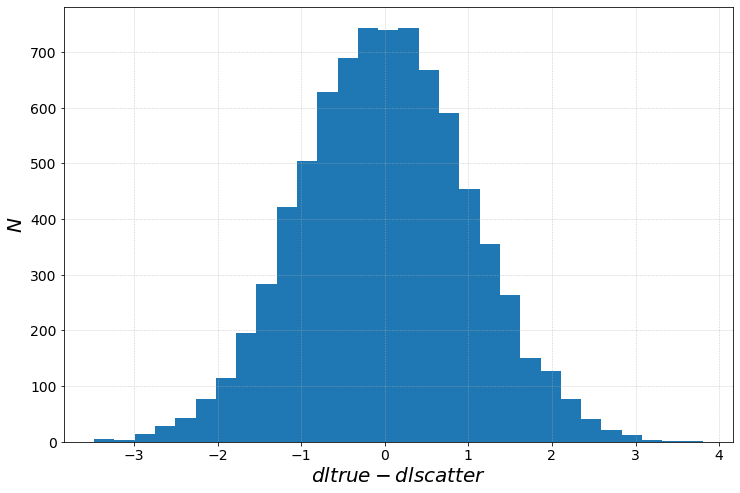

In [147]:
fig, ax = plt.subplots(1, figsize=(12,8)) #crea un tupla che poi è più semplice da gestire
ax.tick_params(axis='both', which='major', labelsize=14)
ax.yaxis.get_offset_text().set_fontsize(14)
ax.grid(linestyle='dotted', linewidth='0.6')#griglia in sfondo
colors=plt.cm.turbo(np.linspace(0.99,0.01,16))


nbins=30
(n_norm, bins_norm, patches)=ax.hist(mynormdiff,bins=nbins,range=(np.min(mynormdiff),np.max(mynormdiff)))

ax.set_xlabel(r'$dl true-dl scatter$', fontsize=20)
ax.set_ylabel(r'$N$', fontsize=20)

In [148]:
mean=np.mean(mydiff)
std=np.std(mydiff)
print(mean,std)
mean=np.mean(mynormdiff)
std=np.std(mynormdiff)
print(mean,std)

12.765330405297618 1775.1839549913798
0.007712739015964009 1.0069292522912985


In [149]:
test=mynormdiff[mynormdiff>=-1]
test=test[test<=1]
print(len(test)/len(mynormdiff))

0.6775
